In [10]:
import torch
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from itertools import groupby
from functools import reduce
from typing import Collection, List
from pathlib import Path
import music21 as m21
musescore_path = '/usr/bin/mscore'
m21.environment.set('musicxmlPath', musescore_path)
m21.environment.set('musescoreDirectPNGPath', musescore_path)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device}.")

Using cuda.


In [2]:
if device == "cuda":
    print(f"Device: {torch.cuda.get_device_name()}.")

Device: NVIDIA GeForce RTX 4090.


To start with lets bring in our import / encode / decode functions from last time.

In [3]:
BEATS_PER_BAR = 4 # beats per bar
DIVISIONS_PER_QUARTER = 4 # i.e. 4 beats per bar and 4 divisions per beat gives 16 divisions per bar
MIDI_NOTE_COUNT = 128
MAX_NOTE_DUR = (8*BEATS_PER_BAR*DIVISIONS_PER_QUARTER)
SEPARATOR_IDX = -1 # separator value for numpy encoding
PIANO_RANGE = (21, 108)
SOS = '<|sos|>' # Start of sequence
EOS = '<|eos|>' # End of sequence
SEP = '<|sep|>' # End of timestep (required for polyphony). Note index -1
 # SEP token must be last, i.e. one place before note tokens, so that adding the note offset still works when encoding
SPECIAL_TOKENS = [SOS, EOS, SEP]
MIDI_NOTE_COUNT = 128
NOTE_TOKENS = [f'n{i}' for i in range(MIDI_NOTE_COUNT)]
DURATION_SIZE = 8 * BEATS_PER_BAR * DIVISIONS_PER_QUARTER + 1 # 8 bars of sixteenth (semiquaver) notes + 1 for 0 length
DURATION_TOKENS = [f'd{i}' for i in range(DURATION_SIZE)]
NOTE_START, NOTE_END = NOTE_TOKENS[0], NOTE_TOKENS[-1]
DURATION_START, DURATION_END = DURATION_TOKENS[0], DURATION_TOKENS[-1]
ALL_TOKENS = SPECIAL_TOKENS + NOTE_TOKENS + DURATION_TOKENS
ALL_TOKENS[0:8]
TIMESIG = f'{BEATS_PER_BAR}/4'

class MusicVocab():
    def __init__(self):
        itos = SPECIAL_TOKENS + NOTE_TOKENS + DURATION_TOKENS
        # Ensure that the vocab is a multiple of 8 for fp16 training
        if len(itos)%8 != 0:
            itos = itos + [f'dummy{i}' for i in range(len(itos)%8)]
        self.itos = itos
        self.stoi = {v:k for k,v in enumerate(self.itos)}

    def to_indices(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their indices."
        return [self.stoi[w] for w in t]

    def to_tokens(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of indices to their tokens."
        items = [self.itos[i] for i in nums]
        return sep.join(items) if sep is not None else items

    @property
    def bos_idx(self): return self.stoi[SOS]
    @property
    def eos_idx(self): return self.stoi[EOS]
    @property
    def sep_idx(self): return self.stoi[SEP]
    @property
    def note_position_enc_range(self): return (self.stoi[SEP], self.stoi[DURATION_END]+1)
    @property
    def note_range(self): return self.stoi[NOTE_START], self.stoi[NOTE_END]+1
    @property
    def duration_range(self): return self.stoi[DURATION_START], self.stoi[DURATION_END]+1

def stream_to_sparse_enc(stream_score, note_size=MIDI_NOTE_COUNT, sample_freq=DIVISIONS_PER_QUARTER, max_note_dur=MAX_NOTE_DUR):    
    # Time is measured in quarter notes since the start of the piece
    # Original states that we are assuming 4/4 time but I don't see why that would be the case. BPB isn't used here.

    # (MusicAutobot author:) TODO: need to order by instruments most played and filter out percussion or include the channel
    highest_time = max(
        stream_score.flatten().getElementsByClass('Note').stream().highestTime,
        stream_score.flatten().getElementsByClass('Chord').stream().highestTime)
    
    # Calculate the maximum number of time steps
    max_timestep = round(highest_time * sample_freq) + 1
    sparse_score = np.zeros((max_timestep, len(stream_score.parts), note_size), dtype=np.int32)

    # Convert a note to a tuple of (pitch,offset,duration)
    def note_data(pitch, note):
        return (pitch.midi, int(round(note.offset*sample_freq)), int(round(note.duration.quarterLength*sample_freq)))

    for idx, part in enumerate(stream_score.parts):
        
        notes = chain.from_iterable(
            [note_data(elem.pitch, elem)] if isinstance(elem, m21.note.Note)
            else [note_data(p, elem) for p in elem.pitches] if isinstance(elem, m21.chord.Chord) 
            else []
            for elem in part.flatten()
        )

        # sort flattened note list by timestep (1), duration (2) so that hits are not overwritten and longer notes have priority
        notes_sorted = sorted(notes, key=lambda x: (x[1], x[2])) 

        for note in notes_sorted:
            if note is not None:
                pitch, timestep, duration = note
                clamped_duration = max_note_dur if max_note_dur is not None and duration > max_note_dur else duration
                sparse_score[timestep, idx, pitch] = clamped_duration
    
    return sparse_score

# Pass in the 'one-hot' encoded numpy score
def sparse_to_position_enc(sparse_score, skip_last_rest=True):

    def encode_timestep(acc, timestep):
        encoded_timesteps, wait_count = acc
        encoded_timestep = timestep_to_position_enc(timestep) # pass in all notes for both instruments, merged list returned
        if len(encoded_timestep) == 0: # i.e. all zeroes at time step
            wait_count += 1
        else:
            if wait_count > 0:
                encoded_timesteps.append([SEPARATOR_IDX, wait_count])
            encoded_timesteps.extend(encoded_timestep)
            wait_count = 1
        return encoded_timesteps, wait_count
    
    encoded_timesteps, final_wait_count = reduce(encode_timestep, sparse_score, ([], 0))

    if final_wait_count > 0 and not skip_last_rest:
        encoded_timesteps.append([SEPARATOR_IDX, final_wait_count]) # add trailing rests

    return np.array(encoded_timesteps).reshape(-1, 2) # reshaping. Just in case result is empty
    
def timestep_to_position_enc(timestep, note_range=PIANO_RANGE):

    note_min, note_max = note_range

    def encode_note_data(note_data, active_note_idx):
        instrument, pitch = active_note_idx
        duration = timestep[instrument, pitch]
        if pitch >= note_min and pitch < note_max:
            note_data.append([pitch, duration, instrument])
        return note_data
    
    active_note_idxs = zip(*timestep.nonzero())
    encoded_notes = reduce(encode_note_data, active_note_idxs, [])
    sorted_notes = sorted(encoded_notes, key=lambda x: x[0], reverse=True) # sort by note (highest to lowest)

    # Dropping instrument information for simplicity.
    # MusicAutobot allows different encoding schemes which include instrument number and split pitch into class / octave.
    return [n[:2] for n in sorted_notes]

def position_to_idx_enc(note_position_score, vocab):
    note_idx_score = note_position_score.copy()
    note_min_idx, _ = vocab.note_range
    dur_min_idx, _ = vocab.duration_range
    
    # Replace note and duration tokens with their index in vocab. 
    # Tokens are the same order as notes and note_min_idx offset is constant so we can apply in one go.
    # Using broadcasting to add the 1D [note_min_idx, dur_min_idx] to the 2D note_idx_score.
    note_idx_score += np.array([note_min_idx, dur_min_idx])
    
    prefix =  np.array([vocab.bos_idx])
    suffix = np.array([vocab.eos_idx])

    return np.concatenate([prefix, note_idx_score.reshape(-1), suffix])

def import_midi_file(file_path):
    midifile = m21.midi.MidiFile()
    if isinstance(file_path, bytes):
        midifile.readstr(file_path)
    else:
        midifile.open(file_path)
        midifile.read()
        midifile.close()
    return midifile

def midifile_to_stream(midifile): 
    return m21.midi.translate.midiFileToStream(midifile)

def midifile_to_idx_score(file_path, vocab):
    midifile = import_midi_file(file_path)
    stream = midifile_to_stream(midifile)
    sparse_score = stream_to_sparse_enc(stream)
    note_pos_score = sparse_to_position_enc(sparse_score)
    return position_to_idx_enc(note_pos_score, vocab)

# Combining notes with different durations into a single chord may overwrite conflicting durations.
def group_notes_by_duration(notes):
    get_note_quarter_length = lambda note: note.duration.quarterLength
    sorted_notes = sorted(notes, key=get_note_quarter_length)
    return [list(g) for k,g in groupby(sorted_notes, get_note_quarter_length)]

def sparse_instrument_to_stream_part(sparse_instrument_score, step_duration):
    part = m21.stream.Part()
    part.append(m21.instrument.Piano())
    
    for t_idx, pitch_values in enumerate(sparse_instrument_score):

        def decode_sparse_note(notes, pitch_index):
            note = m21.note.Note(pitch_index)
            quarters = sparse_instrument_score[t_idx, pitch_index]
            note.duration = m21.duration.Duration(float(quarters) * step_duration.quarterLength)
            notes.append(note)
            return notes
        
        pitch_idxs = np.nonzero(pitch_values)[0]

        if len(pitch_idxs) != 0: 
            notes = reduce(decode_sparse_note, pitch_idxs, [])
            for note_group in group_notes_by_duration(notes):
                note_position = t_idx*step_duration.quarterLength
                if len(note_group) == 1:
                    part.insert(note_position, note_group[0])
                else:
                    chord = m21.chord.Chord(note_group)
                    part.insert(note_position, chord)

    return part

def sparse_to_stream_enc(sparse_score, bpm=120):
    step_duration = m21.duration.Duration(1. / DIVISIONS_PER_QUARTER)
    stream = m21.stream.Score()
    stream.append(m21.meter.TimeSignature(TIMESIG))
    stream.append(m21.tempo.MetronomeMark(number=bpm))

    # Not required here but left as example of options available
    stream.append(m21.key.KeySignature(0))
    
    for inst in range(sparse_score.shape[1]):
        part = sparse_instrument_to_stream_part(sparse_score[:,inst,:], step_duration)
        stream.append(part)
    
    # Again, not required yet but left as example
    stream = stream.transpose(0)
    
    return stream

def position_to_sparse_enc(note_position_score):

    # Add all the separator durations as they denote the elapsed time
    score_length = sum(timestep[1] for timestep in note_position_score if timestep[0] == SEPARATOR_IDX) + 1
    
    # Single instrument as we discarded the instrument information when encoding
    # We will adapt to handle multiple instruments later
    instrument = 0

    def decode_note_position_step(acc, note_pos_step):
        timestep, sparse_score = acc
        note, duration = note_pos_step.tolist()
        if note < SEPARATOR_IDX:  # Skip special token
            return acc
        elif note == SEPARATOR_IDX:  # Time elapsed
            return (timestep + duration, sparse_score)
        else:
            sparse_score[timestep, instrument, note] = duration
            return (timestep, sparse_score)

     # (timesteps, instruments, pitches)
    initial_sparse_score = np.zeros((score_length, 1, MIDI_NOTE_COUNT))
    _, final_sparse_score = reduce(decode_note_position_step, note_position_score, (0, initial_sparse_score))

    return final_sparse_score

# No validation of note position encoding included to keep it simple for now
def idx_to_position_enc(idx_score, vocab):
    
    # Filter out special tokens
    notes_durs_start, notes_durs_end = vocab.note_position_enc_range # range of non-special token values
    notes_durations_idx_score = idx_score[np.where((idx_score >= notes_durs_start) & (idx_score < notes_durs_end))]

    # Reshape into pairs of (note, duration). If odd number of tokens, discard the last token.
    if notes_durations_idx_score.shape[0] % 2 != 0:
        notes_durations_idx_score = notes_durations_idx_score[:-1]

    position_score = notes_durations_idx_score.copy().reshape(-1, 2)
    
    # Shift token index values to note and duration values
    if position_score.shape[0] == 0: 
        return position_score
    else:
        note_min_idx, _ = vocab.note_range
        dur_min_idx, _ = vocab.duration_range
        position_score -= np.array([note_min_idx, dur_min_idx])
        return position_score

def idx_to_stream_enc(idx_score, vocab):
    position_score = idx_to_position_enc(idx_score, vocab)
    sparse_score = position_to_sparse_enc(position_score)
    return sparse_to_stream_enc(sparse_score)

vocab = MusicVocab()

And a quick test...

In [ ]:
single_bar_path = Path('data/midi/single_bar_example.mid')
single_bar_idx_score = midifile_to_idx_score(single_bar_path, vocab)
single_bar_stream = idx_to_stream_enc(single_bar_idx_score, vocab)
single_bar_stream.plot()

# Loading Data

We have two options when loading data from multiple sources into training batches.

1. Concatenate all the sources into one long sequence, with a separator token between (`<|eos|>` in our case). We can then just window through the sequence to pick batches.

2. Treat each source as a single batch, and pad shorter sequences to the length of the longest so they are all consistent.

`1.` is simpler to implement, although it does make it harder for the model to distinguish between sequence boundaries as it has to learn that nothing before an `<|eos|>` token is relevant to anything after it.

`2.` on the other hand has explicit sequence boundaries, but wastes training resources processing `<|pad|>` tokens.

For this reason, lets go with `1.`

The process will be

- Load each file
- Tokenise it
- Split them into x samples and y labels
- Concatenate all the xs into one long collection of samples and the ys into one collection of labels

> If we assign labels *before* we concatenate then we avoid having anything follow `<|eos|>` in the training data.

In [ ]:
vg_path = Path('data/midi/vg')
vg_file_names = [f for f in os.listdir(vg_path) if os.path.isfile(os.path.join(vg_path, f))]
vg_file_names[0:3]

In [ ]:
len(vg_file_names)

### Bigram revisited

To start with, let's do a simple bigram encoding as we did in the previous workbook, but this time on the bigger dataset.

In [ ]:
def bigram_encode(file_names, vocab):
    xs, ys = [], []
    for file_name in file_names:
        file_path = Path(vg_path, file_name)
        idx_score = midifile_to_idx_score(file_path, vocab)
        xs.append(idx_score[:-1])
        ys.append(idx_score[1:])
    return np.concatenate(xs), np.concatenate(ys)

vg_bigram_samples = Path(f'data/numpy/vg/bigram_samples.npy')
vg_bigram_labels = Path(f'data/numpy/vg/bigram_labels.npy')

if vg_bigram_samples.exists() and vg_bigram_labels.exists():
    xs, ys = np.load(vg_bigram_samples, allow_pickle=True), np.load(vg_bigram_labels, allow_pickle=True)
else:
    xs, ys = bigram_encode(vg_file_names, vocab)
    np.save(vg_bigram_samples, xs)
    np.save(vg_bigram_labels, ys)

xs.shape, ys.shape

In [ ]:
for _, (x, y) in enumerate(zip(xs[:5], ys[:5])):
    print(f'x: {vocab.to_tokens([x])}, y:{vocab.to_tokens([y])}')

# MLP

We are going to try to roughly follow part 2 of Karpathy's Makemore and use a simple MLP to improve our bigram results (along with a bigger data set!)

Spoiler alert, it still won't be very good, but we might see a glimmer of improvement....

### Expanding the context

In our bigram encoding, we asked 'if the input sequence is `[a]`, what is the output token?'.

Now we want to expand the input context - i.e. we are asking 'if the input is `[a, b, c]`, what is the output token?'

We still want to only move the window forward by one token for each example to get the most we can out of our dataset.

Let's also take the opportunity to load an even bigger data set.

In [4]:
vg_large_path = Path('data/midi/vg_large')
vg_large_file_names = [f for f in os.listdir(vg_large_path) if os.path.isfile(os.path.join(vg_large_path, f))]
vg_large_file_names[0:3]

['Ace Attorney_Nintendo 3DS_Phoenix Wright Ace Attorney Spirit of Justice_Cheerful People.mid',
 'Ace Attorney_Nintendo DS_Ace Attorney Investigations Miles Edgeworth_Kay Faraday The Great Truth Burglar.mid',
 'Ace Attorney_Nintendo DS_Ace Attorney Investigations Miles Edgeworth_Pursuit Lying Coldly.mid']

In [5]:
len(vg_large_file_names)

3839

In [6]:
def block_encode(file_names, vocab, block_size):
    xs, ys = [], []
    for file_name in file_names:
        file_path = Path(vg_large_path, file_name)
        idx_score = midifile_to_idx_score(file_path, vocab)
        for i in range(0, len(idx_score) - block_size, 1):
            xs.append(idx_score[i:i+block_size])
            ys.append(idx_score[i+block_size])
    return np.stack(xs), ys # stack xs to create 2D tensor

block_size = 3
vg_large_block_samples = Path(f'data/numpy/vg_large/block_{block_size}_samples.npy')
vg_large_block_labels = Path(f'data/numpy/vg_large/block_{block_size}_labels.npy')

if vg_large_block_samples.exists() and vg_large_block_labels.exists():
    xs, ys = np.load(vg_large_block_samples, allow_pickle=True), np.load(vg_large_block_labels, allow_pickle=True)
else:
    xs, ys = block_encode(vg_large_file_names, vocab, block_size)
    np.save(vg_large_block_samples, xs)
    np.save(vg_large_block_labels, ys)

xs.shape, len(ys)

((11588467, 3), 11588467)

In [ ]:
for _, (x, y) in enumerate(zip(xs[:5], ys[:5])):
    print(f'x: {vocab.to_tokens(x)}, y:{vocab.to_tokens([y])}')

In [ ]:
for _, (x, y) in enumerate(zip(xs[-5:], ys[-5:])):
    print(f'x: {vocab.to_tokens(x)}, y:{vocab.to_tokens([y])}')

In [7]:
X = torch.tensor(xs, device=device)
Y = torch.tensor(ys, device=device)

In [8]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([11588467, 3]), torch.int64, torch.Size([11588467]), torch.int64)

#### Embeddings

Embeddings are just a lookup from vocab index to tensor. The length of the tensor compared to the number of distinct tokens determines how much compression we are asking the model to perform.

We can start by initialising the lookup as random numbers. It will ultimately be trained as the first layer of our MLP.

In [9]:
vocab_size = len(vocab.itos)
embed_size = 2
C = torch.randn((vocab_size, embed_size), device=device)

> To pick out a value we could index into this tensor directly, or multiply by a one-hot encoded index as we did in the last notebook.

We can index into `C` using `X` directly to essentially convert X into embedding values.

In [ ]:
emb = C[X]
emb.shape

### Hidden layer

We have a context window of 3 and an embedding size of 2, so 6 inputs per example.

These need to be connected to each neuron in our hidden layer.

In [ ]:
neurons = 100
W1 = torch.randn((embed_size*block_size, neurons), device=device)
b1 = torch.randn((neurons), device=device)

We also need to transform the `[11588467, 3, 2]` tensor to `11588467, 6`.

In [ ]:
emb_flattened = emb.view(-1, (block_size*embed_size))
emb_flattened.shape

Now we can multiply the embeddings by our hidden layer weights and pass them through the `tanh` non-linearity to get our activations.

In [ ]:
h = torch.tanh(emb_flattened @ W1 + b1)
h.shape

Here are our activations:

In [ ]:
h

Now we need our output layer

In [ ]:
W2 = torch.randn((neurons, vocab_size), device=device)
b2 = torch.randn((vocab_size), device=device)
logits = h @ W2 + b2
logits.shape

Now we want to pluck out the Yth element of the probablilities to see how well we did by calculating our loss using the negative log likelyhood.

In [ ]:
# This is how we did it in the previous notebook
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdim=True)
# loss = -prob[torch.arange(len(Y)), Y].log().mean() # Get the Yth element of each row to calculate the negative log likelihood

# More efficient
loss = F.cross_entropy(logits, Y)
loss

Let's collect up our parameters and enable gradient tracking for them.

That will allow us to loop the above process, tweaking our weights a little at each iteration.

We will get better results if we train on mini-batches. This will give us a less reliable gradient, but allow us to iterate much much faster.

In [17]:
# These were selected partially by copying Karpthy's settings and partially by trial and error. We could do a proper hyperparameter search.
neurons = 100
embed_size = 2
C = torch.randn((vocab_size, embed_size), device=device)
W1 = torch.randn((embed_size*block_size, neurons), device=device)
b1 = torch.randn((neurons), device=device)
W2 = torch.randn((neurons, vocab_size), device=device)
b2 = torch.randn((vocab_size), device=device)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.numel() for p in parameters)

27892

1.9056638479232788


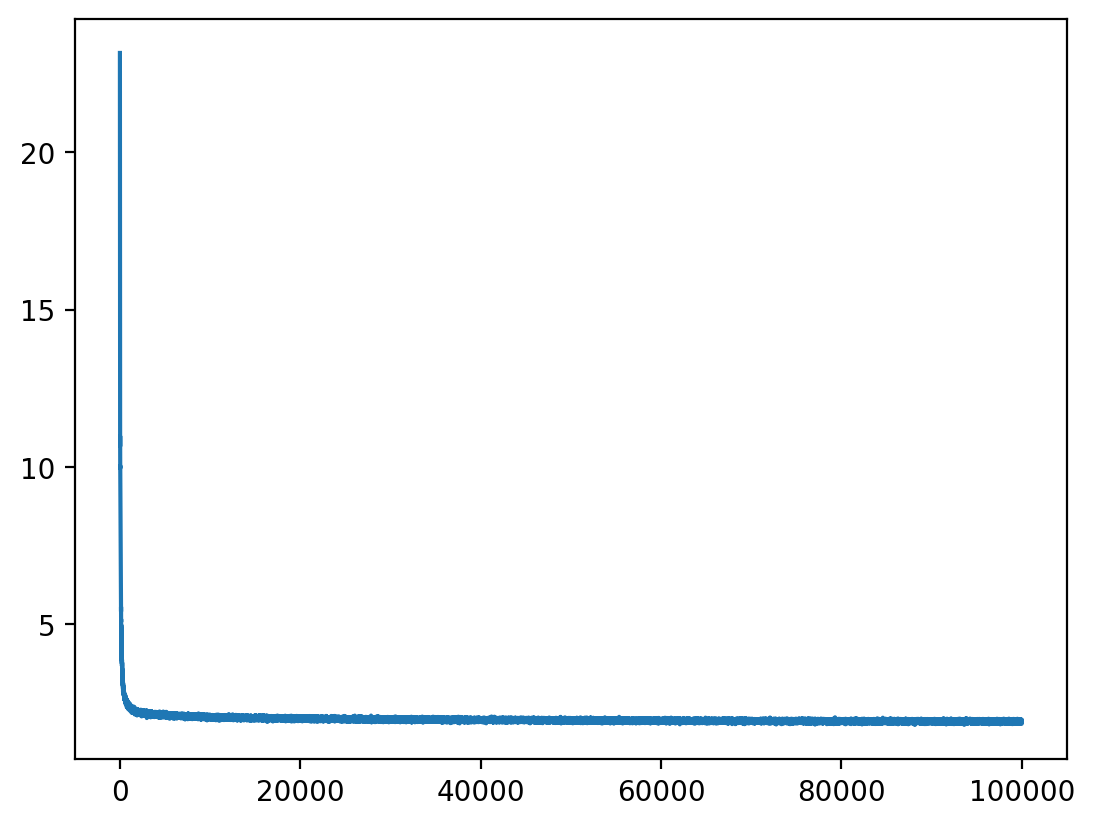

In [18]:
iterations = 100000
learning_rate = 0.1
minibatch_size = 4096

losses = []    
for _ in range(iterations):

    # Configure minibatch
    ix = torch.randint(0, X.shape[0], (minibatch_size,)) # randomly pick indices
    labels = Y[ix]

    # Forward pass
    emb = C[X[ix]] # (minibatch_size, block_size, embed_size) 
    emb_flattened = emb.view(-1, (block_size*embed_size))
    h = torch.tanh(emb_flattened @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, labels)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update weights
    for p in parameters:
        p.data -= learning_rate * p.grad

    losses.append(loss.item())

plt.plot(losses)

And our loss across the whole batch?

In [19]:
emb = C[X[ix]] # (minibatch_size, block_size, embed_size) 
emb_flattened = emb.view(-1, (block_size*embed_size))
h = torch.tanh(emb_flattened @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, labels)
loss.item()

1.9035277366638184

Of course, up until now we haven't evaluated against a test set - we are just memorising the training data.